In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Intal FoolBox Library**

In [2]:
!pip install foolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


# **ProjectedGradientDescentAttack**

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


308/308 [==============================] - 3s 9ms/step
Accuracy on clean data: 100.00%
308/308 [==============================] - 2s 5ms/step

Adversarial test data: eps:0.2
Accuracy on adversarial examples: 0.00%


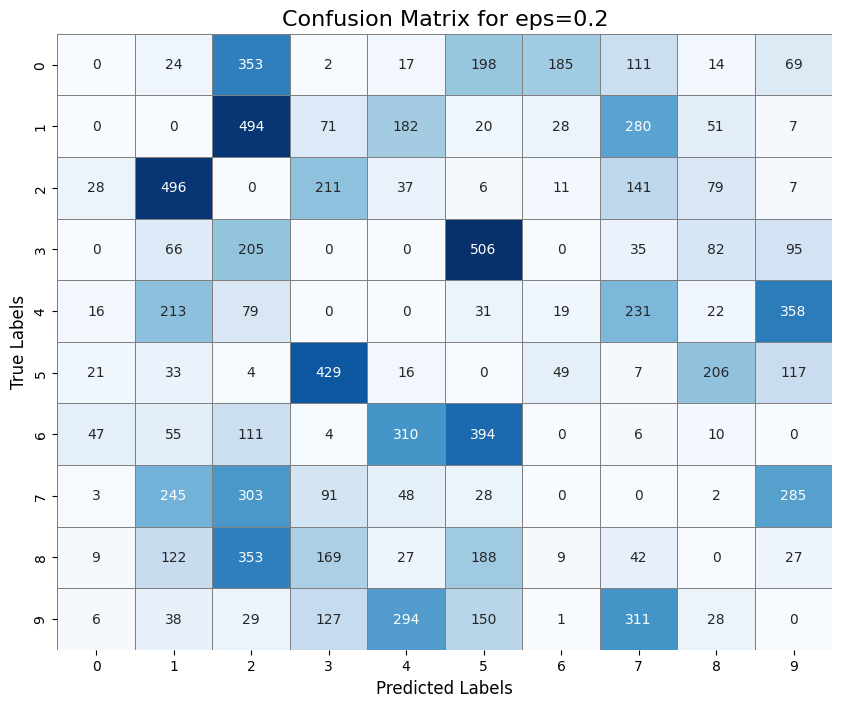

In [3]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import eagerpy as ep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')  # Cast labels to int32

# Create a Foolbox model
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))



# Calculate accuracy on clean data
linfpgd_predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(linfpgd_predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Convert data to TensorFlow tensors
images = tf.convert_to_tensor(correct_examples)
labels = tf.convert_to_tensor(correct_labels, dtype=tf.int32)  # Cast labels to int32

# Create a Foolbox model for TensorFlow
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Apply an FGSM attack
attack = fb.attacks.LinfPGD()
epsilons = [0.2]
raw_advs, linfpgd_clipped_advs, linfpgd_success = attack(fmodel, images, labels, epsilons=epsilons)




# Assuming 'clipped_advs' are the adversarial examples for different epsilons
for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # Predict the labels of the adversarial examples
    linfpgd_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate accuracy on adversarial examples
    accuracy_adv = np.mean(linfpgd_y_adv == correct_labels)
    print(f"\nAdversarial test data: eps:{eps}")
    print(f"Accuracy on adversarial examples: {accuracy_adv * 100:.2f}%")

    # Calculate the confusion matrix
    cm_pgd = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))

    # Draw and save the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a mask for the diagonal elements
    mask = np.eye(len(cm_pgd), dtype=bool)

    # Plot the heatmap for off-diagonal elements using the mask
    sns.heatmap(cm_pgd, mask=mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Plot the heatmap for diagonal elements using the inverse of the mask
    sns.heatmap(cm_pgd, mask=~mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Labels, title, and ticks
    label_names = [f'{i}' for i in range(10)]
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_title(f'Confusion Matrix for eps={eps}', fontsize=16)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # Save the plot
    image_filename = f'confusion_matrix_eps_{eps}.png'
    plt.savefig(image_filename, bbox_inches='tight')
    plt.show()  # Display the figure in the notebook


In [5]:
# Calculate and report the robust accuracy
# Convert 'success' to float, and calculate the mean
robust_accuracy = 1 - tf.reduce_mean(tf.cast(linfpgd_success, tf.float32), axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.numpy() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.2   :  0.0 %


In [6]:
linfpgd_accuracies = []

for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # ... existing code ...
    linfpgd_accuracies.append(accuracy_adv * 100)



# **Plotting the bar chart for true label counts and predicted label counts**


308/308 [==============================] - 3s 9ms/step


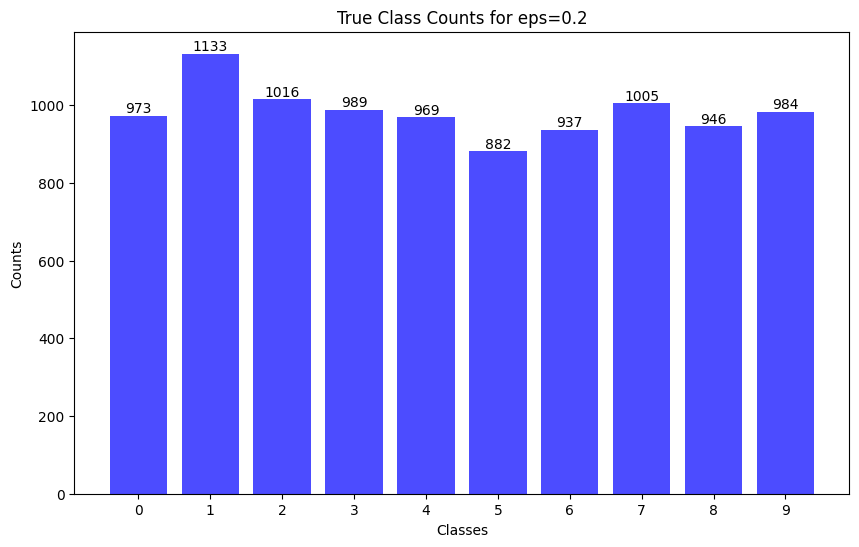

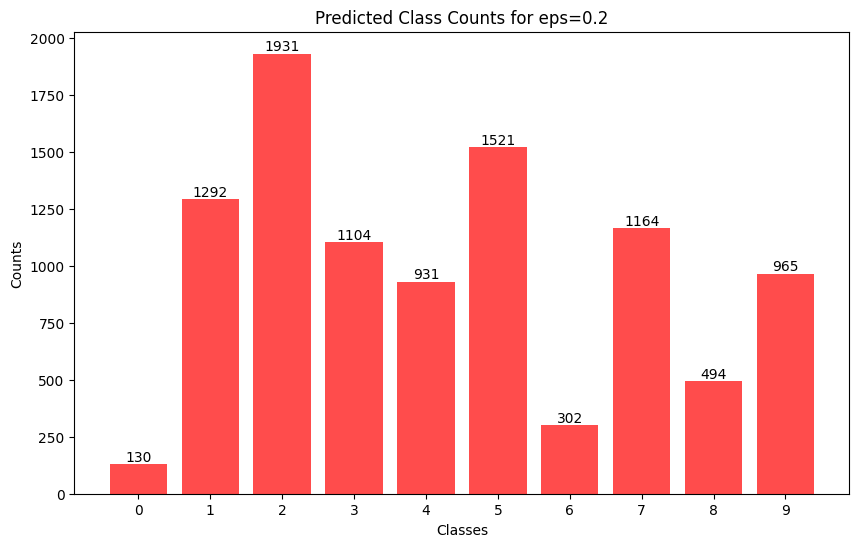

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # Predict the labels of the adversarial examples
    linfpgd_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))

    # Count of each class in true labels
    true_label_counts = np.sum(cm, axis=1)

    # Count of each class in predicted labels
    predicted_label_counts = np.sum(cm, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), true_label_counts, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'True Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    # Plotting the bar chart for predicted label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), predicted_label_counts, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()




# **AdamPGD**

308/308 [==============================] - 3s 9ms/step
Accuracy on clean data: 100.00%
308/308 [==============================] - 2s 6ms/step

Adversarial test data: eps:0.2
Accuracy on adversarial examples: 0.00%


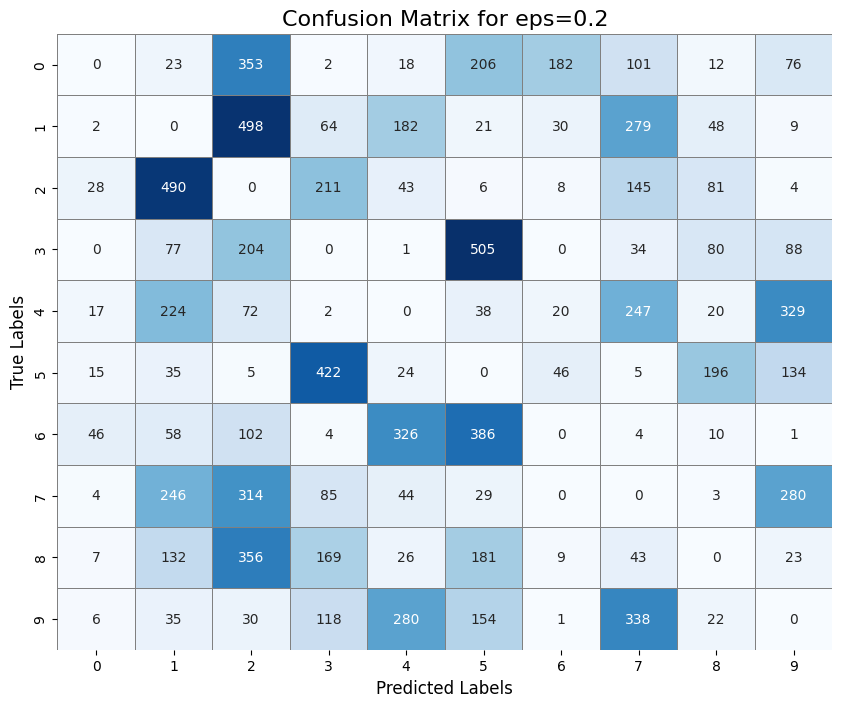

In [8]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import eagerpy as ep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')  # Cast labels to int32

# Create a Foolbox model
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))



# Calculate accuracy on clean data
adam_predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(adam_predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Convert data to TensorFlow tensors
images = tf.convert_to_tensor(correct_examples)
labels = tf.convert_to_tensor(correct_labels, dtype=tf.int32)  # Cast labels to int32

# Create a Foolbox model for TensorFlow
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Apply an FGSM attack
attack = fb.attacks.LinfAdamPGD()
epsilons = [0.2]
adam_raw_advs, adam_clipped_advs, adam_success = attack(fmodel, images, labels, epsilons=epsilons)




# Assuming 'clipped_advs' are the adversarial examples for different epsilons
for eps, advs_ in zip(epsilons, adam_clipped_advs):
    # Predict the labels of the adversarial examples
    adam_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate accuracy on adversarial examples
    accuracy_adv = np.mean(adam_y_adv == correct_labels)
    print(f"\nAdversarial test data: eps:{eps}")
    print(f"Accuracy on adversarial examples: {accuracy_adv * 100:.2f}%")

    # Calculate the confusion matrix
    cm_adam = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Draw and save the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a mask for the diagonal elements
    mask = np.eye(len(cm_adam), dtype=bool)

    # Plot the heatmap for off-diagonal elements using the mask
    sns.heatmap(cm_adam, mask=mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Plot the heatmap for diagonal elements using the inverse of the mask
    sns.heatmap(cm_adam, mask=~mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Labels, title, and ticks
    label_names = [f'{i}' for i in range(10)]
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_title(f'Confusion Matrix for eps={eps}', fontsize=16)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # Save the plot
    image_filename = f'confusion_matrix_eps_{eps}.png'
    plt.savefig(image_filename, bbox_inches='tight')
    plt.show()  # Display the figure in the notebook


308/308 [==============================] - 2s 5ms/step


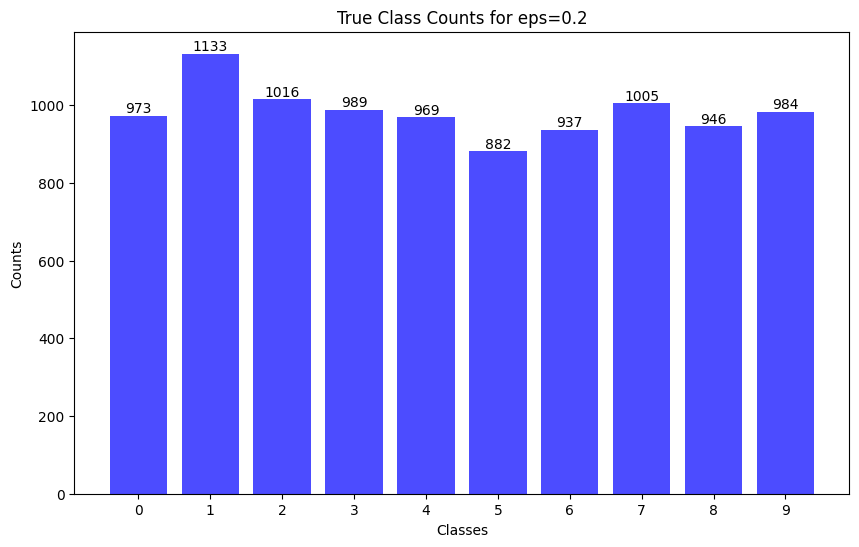

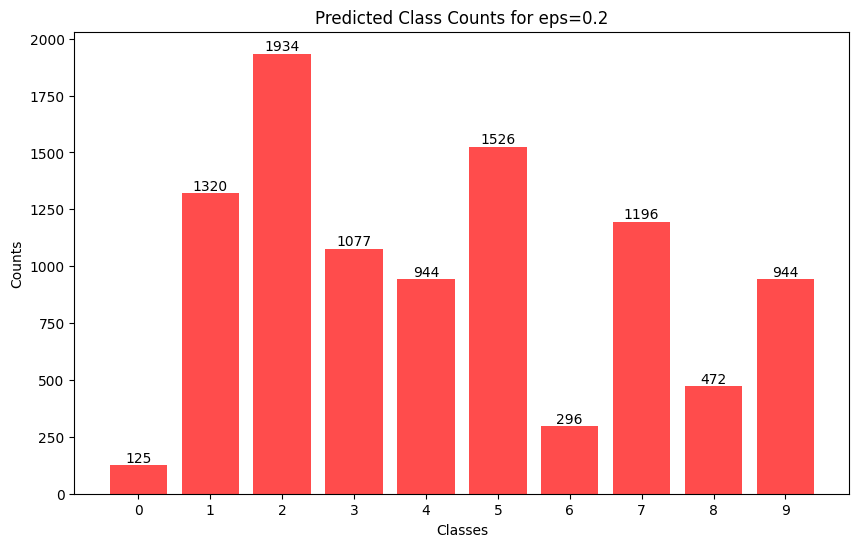

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, advs_ in zip(epsilons, adam_clipped_advs):
    # Predict the labels of the adversarial examples
    adam_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate the confusion matrix
    adam_cm = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in true labels
    true_label_counts = np.sum(adam_cm, axis=1)

    # Count of each class in predicted labels
    adam_predicted_label_counts = np.sum(adam_cm, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), true_label_counts, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'True Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    # Plotting the bar chart for predicted label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), adam_predicted_label_counts, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()




# **compare both attacks Predicted Counts in Parellel**

308/308 [==============================] - 3s 9ms/step


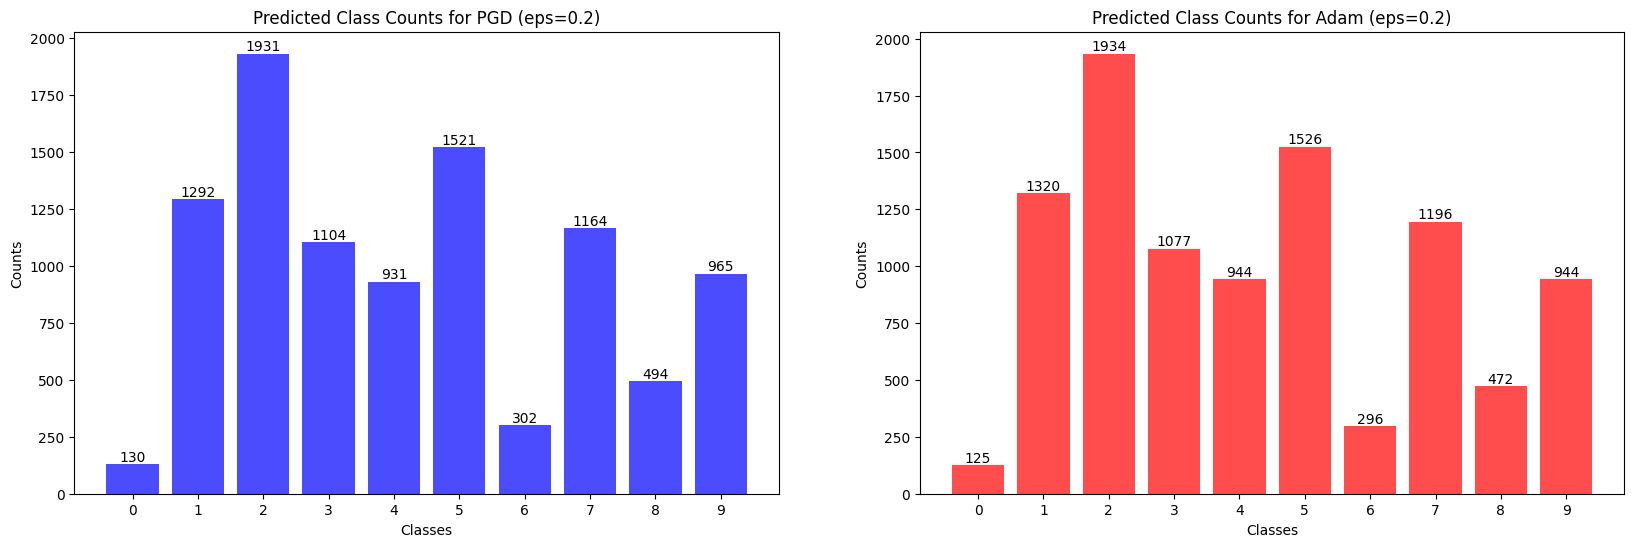

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, (advs1_, advs2_) in zip(epsilons, zip(linfpgd_clipped_advs, adam_clipped_advs)):
    # Predict the labels of the adversarial examples for both attacks
    linfpgd_y_adv = np.argmax(model.predict(advs1_), axis=1)
    adam_y_adv = np.argmax(model.predict(advs2_), axis=1)

    # Calculate the confusion matrix for both attacks
    cm1 = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))
    cm2 = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in true labels (assuming it's the same for both attacks)
    true_label_counts = np.sum(cm1, axis=1)

    # Count of each class in predicted labels for both attacks
    predicted_label_counts1 = np.sum(cm1, axis=0)
    predicted_label_counts2 = np.sum(cm2, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(20, 6))

    # Subplot for the first attack
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(10), predicted_label_counts1, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for PGD (eps={eps})')
    plt.xticks(range(10))
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    # Subplot for the second attack
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(10), predicted_label_counts2, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for Adam (eps={eps})')
    plt.xticks(range(10))
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()


# **compare both attacks Predicted Counts in one graph**

308/308 [==============================] - 3s 8ms/step


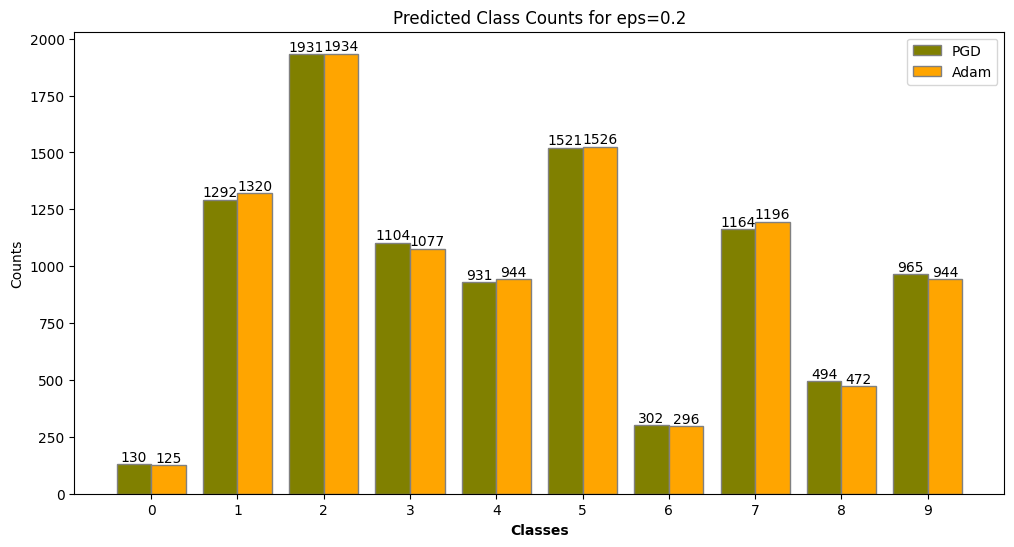

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, (advs1_, advs2_) in zip(epsilons, zip(linfpgd_clipped_advs, adam_clipped_advs)):
    # Predict the labels of the adversarial examples for both attacks
    linfpgd_y_adv = np.argmax(model.predict(advs1_), axis=1)
    adam_y_adv = np.argmax(model.predict(advs2_), axis=1)

    # Calculate the confusion matrix for both attacks
    cm1 = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))
    cm2 = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in predicted labels for both attacks
    predicted_label_counts1 = np.sum(cm1, axis=0)
    predicted_label_counts2 = np.sum(cm2, axis=0)

    # Number of classes
    n_classes = range(10)

    # Plotting the grouped bar chart
    plt.figure(figsize=(12, 6))
    bar_width = 0.4  # width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(predicted_label_counts1))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, predicted_label_counts1, color='olive', width=bar_width, edgecolor='grey', label='PGD')
    plt.bar(r2, predicted_label_counts2, color='orange', width=bar_width, edgecolor='grey', label='Adam')

    # Add labels, title, and legend
    plt.xlabel('Classes', fontweight='bold')
    plt.ylabel('Counts')
    plt.xticks([r + bar_width/2 for r in range(len(predicted_label_counts1))], n_classes)
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.legend()

    # Adding count annotations on each bar
    for i in range(len(r1)):
        plt.text(r1[i], predicted_label_counts1[i], int(predicted_label_counts1[i]), ha='center', va='bottom')
        plt.text(r2[i], predicted_label_counts2[i], int(predicted_label_counts2[i]), ha='center', va='bottom')

    plt.show()


In [9]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# Assuming y_adv_fgsm and y_adv_linfpgd are the predictions
misclassified_adam = [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(linfpgd_y_adv)) if linfpgd_y_adv[i] != correct_labels[i]]

jaccard_index = jaccard_similarity(misclassified_adam, misclassified_linfpgd)
print(f"Jaccard Similarity: {jaccard_index}")


Jaccard Similarity: 1.0


In [10]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# Assuming y_adv_fgsm and y_adv_linfpgd are the predictions
misclassified_adam = [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(linfpgd_y_adv)) if linfpgd_y_adv[i] != correct_labels[i]]

jaccard_index = jaccard_similarity(misclassified_adam, misclassified_linfpgd)
print(f"Jaccard Similarity: {jaccard_index}")
# Assuming y_adv_fgsm and y_adv_linfpgd are the predicted labels from the FGSM and LinfPGD attacks, respectively
misclassified_adam= [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(linfpgd_y_adv)) if linfpgd_y_adv[i] != correct_labels[i]]

# Find common and unique indices
common_indices = set(misclassified_adam).intersection(set(misclassified_linfpgd))
unique_adam = set(misclassified_adam).difference(common_indices)
unique_linfpgd = set(misclassified_linfpgd).difference(common_indices)

print(f"Commonly Misclassified: {len(common_indices)}")
print(f"Unique in Adam: {len(unique_adam)}")
print(f"Unique in LinfPGD: {len(unique_linfpgd)}")


Jaccard Similarity: 1.0
Commonly Misclassified: 9834
Unique in Adam: 0
Unique in LinfPGD: 0


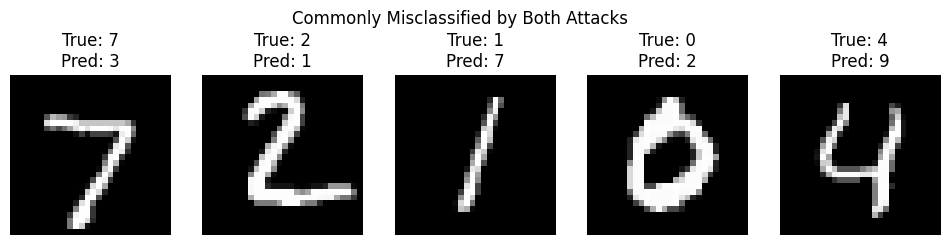

<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

def plot_examples(indices, title, examples, labels, predictions, num_examples=5):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)

    for i, index in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(examples[index].squeeze(), cmap='gray') # Assuming the examples are grayscale images
        plt.title(f"True: {labels[index]}\nPred: {predictions[index]}")
        plt.axis('off')

# Assuming y_adv_fgsm and y_adv_linfpgd are the predicted labels from the FGSM and LinfPGD attacks, respectively
misclassified_adam = [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(linfpgd_y_adv)) if linfpgd_y_adv[i] != correct_labels[i]]

# Find common and unique indices
common_indices = list(set(misclassified_adam).intersection(set(misclassified_linfpgd)))
unique_adam_indices = list(set(misclassified_adam).difference(common_indices))
unique_linfpgd_indices = list(set(misclassified_linfpgd).difference(common_indices))

# Plot examples
plot_examples(common_indices, 'Commonly Misclassified by Both Attacks', correct_examples, correct_labels, adam_y_adv)
plot_examples(unique_adam_indices, 'Unique Misclassified by Adam', correct_examples, correct_labels, adam_y_adv)
plot_examples(unique_linfpgd_indices, 'Unique Misclassified by LinfPGD', correct_examples, correct_labels, linfpgd_y_adv)


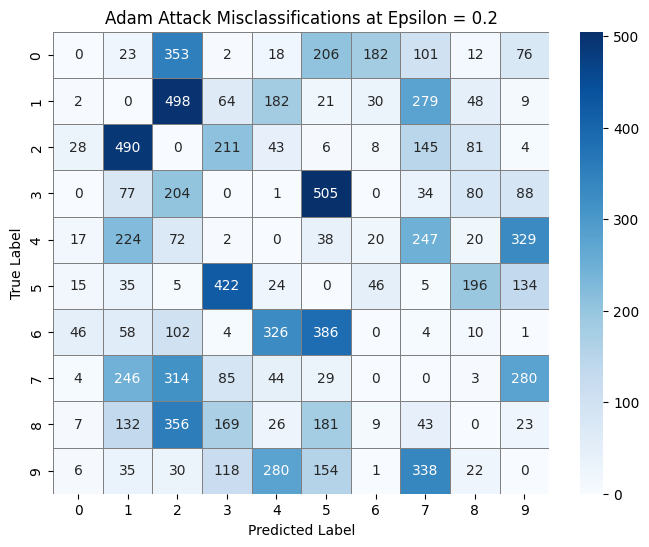

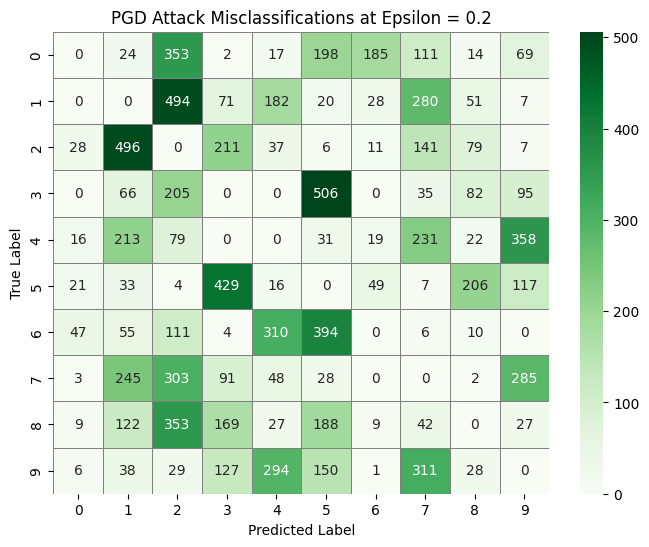

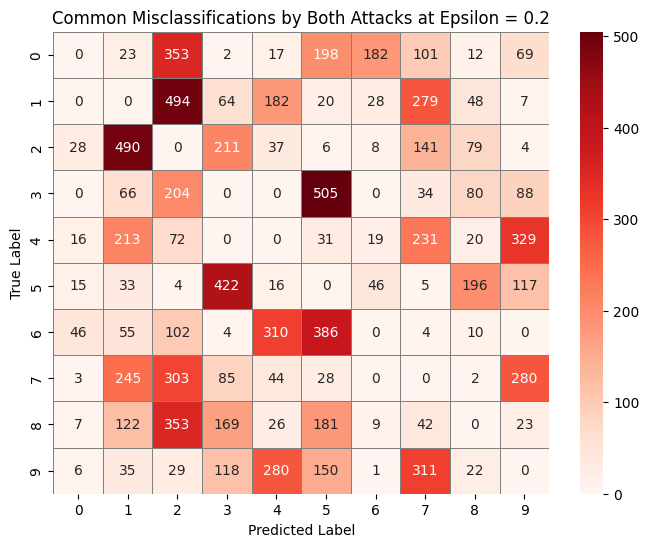

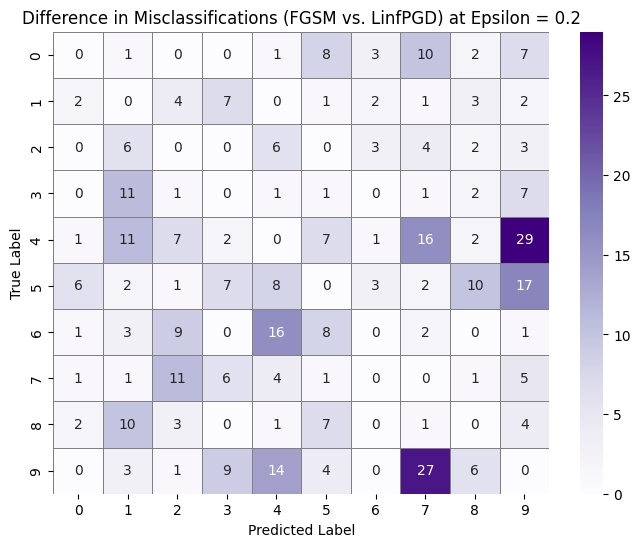

In [12]:
for eps_index, eps in enumerate(epsilons):
    # Assuming you have computed the confusion matrices for FGSM and LinfPGD attacks at each epsilon value
    # cm_fgsm = ... (Computed for FGSM using adversarial examples at eps)
    # cm_linfpgd = ... (Computed for LinfPGD using adversarial examples at eps)

    # Compute common misclassifications
    common_misclassifications = np.minimum(cm_adam, cm_pgd)

    # Compute the absolute difference between the confusion matrices
    cm_difference = np.abs(cm_adam - cm_pgd)

    # Heatmap for FGSM Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray')
    plt.title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for LinfPGD Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray')
    plt.title(f'PGD Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Common Misclassifications by Both Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(common_misclassifications, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray')
    plt.title(f'Common Misclassifications by Both Attacks at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Differences between Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray')
    plt.title(f'Difference in Misclassifications (FGSM vs. LinfPGD) at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [13]:
pip install matplotlib-venn


In [14]:

# Finding misclassified indices
misclassified_linfpgd_indices = np.where(linfpgd_y_adv != correct_labels)[0]

# Convert to a set (if needed for Venn Diagram)
misclassified_linfpgd_indices = set(misclassified_linfpgd_indices)


In [15]:

# Finding misclassified indices
misclassified_adam_indices = np.where(adam_y_adv != correct_labels)[0]

# Convert to a set (if needed for Venn Diagram)
misclassified_adam_indices = set(misclassified_adam_indices)


In [16]:
# Common misclassifications (intersection)
common_indices = misclassified_adam_indices & misclassified_linfpgd_indices

# Unique misclassifications for FGSM (difference)
unique_adam_indices = misclassified_adam_indices - misclassified_linfpgd_indices

# Unique misclassifications for LinfPGD (difference)
unique_linfpgd_indices = misclassified_linfpgd_indices - misclassified_adam_indices


In [17]:
def plot_examples(indices, examples, title, num_rows=1, num_cols=5):
    plt.figure(figsize=(2 * num_cols, 2 * num_rows))
    plt.suptitle(title)
    for i, index in enumerate(list(indices)[:num_rows*num_cols]):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(examples[index].reshape(28, 28), cmap='gray')  # Adjust for your data
        plt.title(f'Index: {index}')
        plt.axis('off')


In [18]:
def display_images(indices, title, num_examples=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=14)
    for i, idx in enumerate(list(indices)[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(correct_examples[idx].squeeze(), cmap='gray')  # Adjust for your data format
        plt.title(f'Index: {idx}')
        plt.axis('off')
    plt.show()



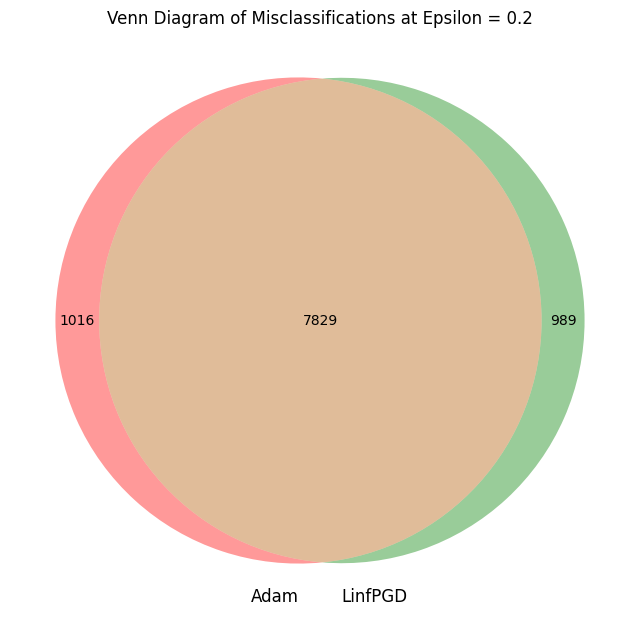

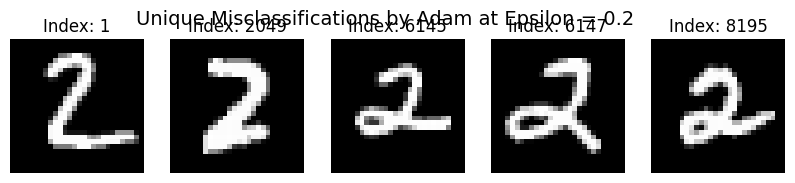

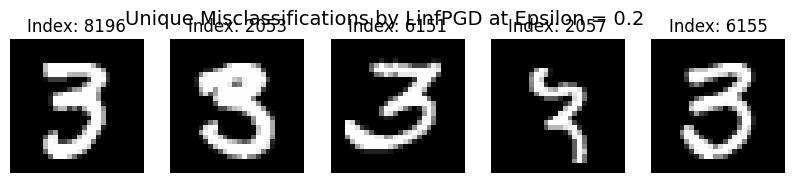

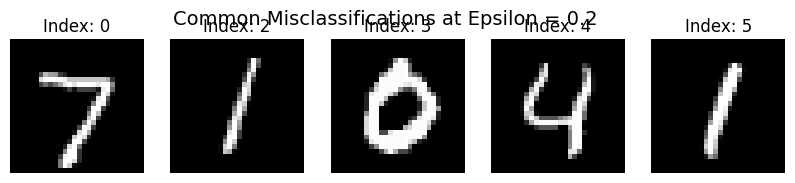

In [19]:
from matplotlib_venn import venn2

for eps_index, eps in enumerate(epsilons):
    # Assuming you have arrays/lists of adversarial examples for each epsilon
    # fgsm_advs[eps_index], linfpgd_advs[eps_index]
    # And corresponding predictions: y_adv_fgsm[eps_index], y_adv_linfpgd[eps_index]

    # Calculate misclassified indices for FGSM and LinfPGD at the current epsilon
    misclassified_adam = set(np.where(adam_y_adv[eps_index] != correct_labels)[0])
    misclassified_linfpgd = set(np.where(linfpgd_y_adv[eps_index] != correct_labels)[0])

    # Unique and Common Misclassifications
    unique_adam = misclassified_adam - misclassified_linfpgd
    unique_linfpgd = misclassified_linfpgd - misclassified_adam
    common = misclassified_adam & misclassified_linfpgd



    # Create Venn diagram for the current epsilon
    plt.figure(figsize=(8, 8))
    venn_diagram = venn2(subsets=(len(unique_adam), len(unique_linfpgd), len(common)),
                         set_labels=('Adam', 'LinfPGD'))
    venn_diagram.get_label_by_id('10').set_text(f'{len(unique_adam)}')
    venn_diagram.get_label_by_id('01').set_text(f'{len(unique_linfpgd)}')
    venn_diagram.get_label_by_id('11').set_text(f'{len(common)}')
    plt.title(f'Venn Diagram of Misclassifications at Epsilon = {eps}')
    plt.show()

    # Display example images for each category (if desired)
    display_images(unique_adam, f"Unique Misclassifications by Adam at Epsilon = {eps}")
    display_images(unique_linfpgd, f"Unique Misclassifications by LinfPGD at Epsilon = {eps}")
    display_images(common, f"Common Misclassifications at Epsilon = {eps}")


 how similar and different counterexamples are generated by the two attacks (LinfPGD and LinfAdamPGD), you can create a stacked bar chart for each class and epsilon value. The goal is to visually compare the number of examples where both attacks agree (either in actual class prediction or predicted class) and where they differ.

In [21]:
num_classes = 10  # Assuming 10 classes
epsilons = [0.2]

# This will hold the comparison matrices for each epsilon
comparison_matrices = []

for eps_index, eps in enumerate(epsilons):
    linfpgd_advs = linfpgd_clipped_advs[eps_index]
    adam_advs = adam_clipped_advs[eps_index]

    linfpgd_predictions = model.predict(linfpgd_advs).argmax(axis=-1)
    adam_predictions = model.predict(adam_advs).argmax(axis=-1)

    comparison_matrix = np.zeros((num_classes, 3))  # Matches, Unique to LinfPGD, Unique to LinfAdamPGD

    for i in range(num_classes):
        indices = np.where(correct_labels == i)

        linfpgd_preds = linfpgd_predictions[indices]
        adam_preds = adam_predictions[indices]

        matches = np.sum(linfpgd_preds == adam_preds)
        unique_linfpgd = np.sum(linfpgd_preds != adam_preds)
        unique_adam = unique_linfpgd  # Assuming equal number of examples, change if necessary

        comparison_matrix[i] = [matches, unique_linfpgd, unique_adam]

    comparison_matrices.append(comparison_matrix)


308/308 [==============================] - 4s 12ms/step


***Matches in the actual class:***
The number of times both attacks correctly predict the actual class.

***Matches in the predicted class:***
The number of times both attacks make the same wrong prediction.

**Unique instances for LinfPGD and LinfAdamPGD:**
Count how many times each attack uniquely identifies or misidentifies class i, both in terms of actual and predicted classes.

In [22]:
import numpy as np

num_classes = 10  # Assuming 10 classes
 #epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
epsilons = [0.2]
comparison_matrices = []

for eps_index, eps in enumerate(epsilons):
    # Retrieving adversarial examples for the current epsilon
    linfpgd_advs = linfpgd_clipped_advs[eps_index]
    adam_advs = adam_clipped_advs[eps_index]

    print(f"\nProcessing epsilon: {eps}")

    # Generating predictions for LinfPGD and LinfAdamPGD attacks
    linfpgd_predictions = model.predict(linfpgd_advs).argmax(axis=-1)
    adam_predictions = model.predict(adam_advs).argmax(axis=-1)

    # Initializing the comparison matrix for this epsilon
    comparison_matrix = np.zeros((num_classes, 6))

    for i in range(num_classes):
        print(f"  Class {i}:")

        # Indices where the true label is class i
        actual_indices = np.where(correct_labels == i)
        #print(f"    Actual indices (class {i}): {actual_indices}")

        # Indices where LinfPGD predicts class i
        predicted_indices_linfpgd = np.where(linfpgd_predictions == i)
        #print(f"    LinfPGD predicted indices (class {i}): {predicted_indices_linfpgd}")

        # Indices where LinfAdamPGD predicts class i
        predicted_indices_adam = np.where(adam_predictions == i)
        #print(f"    LinfAdamPGD predicted indices (class {i}): {predicted_indices_adam}")

        # Calculating metrics
        matches_actual = np.sum(linfpgd_predictions[actual_indices] == adam_predictions[actual_indices])
        matches_predicted = np.sum(linfpgd_predictions[predicted_indices_linfpgd] == adam_predictions[predicted_indices_adam])

        unique_linfpgd_actual = np.sum(linfpgd_predictions[actual_indices] != adam_predictions[actual_indices])
        unique_linfpgd_predicted = np.sum(linfpgd_predictions[predicted_indices_linfpgd] != adam_predictions[predicted_indices_linfpgd])

        unique_adam_actual = np.sum(adam_predictions[actual_indices] != linfpgd_predictions[actual_indices])
        unique_adam_predicted = np.sum(adam_predictions[predicted_indices_adam] != linfpgd_predictions[predicted_indices_adam])

        # Updating the comparison matrix for class i
        comparison_matrix[i] = [matches_actual, matches_predicted, unique_linfpgd_actual, unique_linfpgd_predicted, unique_adam_actual, unique_adam_predicted]

        print(f"    Metrics for class {i}: {comparison_matrix[i]}")

    comparison_matrices.append(comparison_matrix)
    print(f"Finished processing epsilon: {eps}\n")

# Print final results
print("Comparison matrices for all epsilon values:")
for eps, matrix in zip(epsilons, comparison_matrices):
    print(f"Epsilon {eps}:\n{matrix}\n")



Processing epsilon: 0.2
308/308 [==============================] - 3s 10ms/step
  Class 0:
    Metrics for class 0: [802.   0. 171.  35. 171.  30.]
  Class 1:
    Metrics for class 1: [844.   0. 289. 176. 289. 204.]
  Class 2:
    Metrics for class 2: [880.   0. 136. 329. 136. 332.]
  Class 3:
    Metrics for class 3: [837.   0. 152. 251. 152. 224.]
  Class 4:
    Metrics for class 4: [785.   0. 184. 211. 184. 224.]
  Class 5:
    Metrics for class 5: [720.   0. 162. 219. 162. 224.]
  Class 6:
    Metrics for class 6: [775.   0. 162.  77. 162.  71.]
  Class 7:
    Metrics for class 7: [818.   0. 187. 246. 187. 278.]
  Class 8:
    Metrics for class 8: [745.   0. 201. 154. 201. 132.]
  Class 9:
    Metrics for class 9: [740.   0. 244. 190. 244. 169.]
Finished processing epsilon: 0.2

Comparison matrices for all epsilon values:
Epsilon 0.2:
[[802.   0. 171.  35. 171.  30.]
 [844.   0. 289. 176. 289. 204.]
 [880.   0. 136. 329. 136. 332.]
 [837.   0. 152. 251. 152. 224.]
 [785.   0. 184.

<ipython-input-22-9ecdac48458f>:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  matches_predicted = np.sum(linfpgd_predictions[predicted_indices_linfpgd] == adam_predictions[predicted_indices_adam])


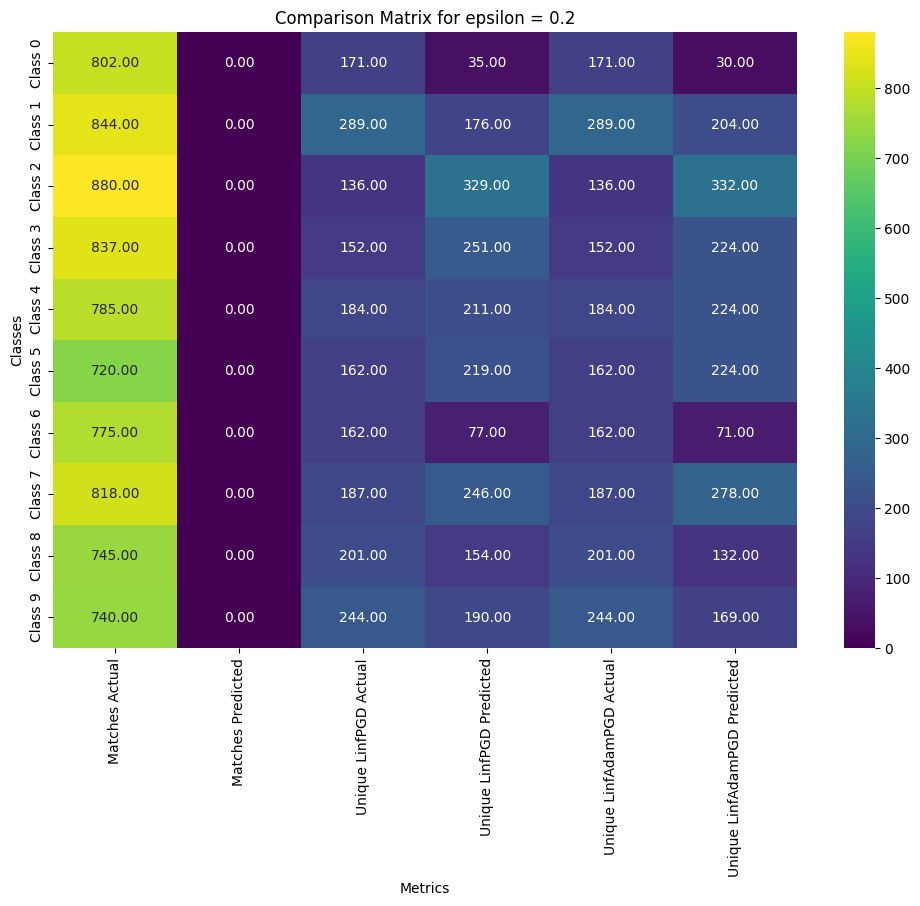

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Column labels for the heatmap
columns = ['Matches Actual', 'Matches Predicted', 'Unique LinfPGD Actual', 'Unique LinfPGD Predicted', 'Unique LinfAdamPGD Actual', 'Unique LinfAdamPGD Predicted']
rows = [f'Class {i}' for i in range(num_classes)]

# Plot a heatmap for each epsilon
for eps_index, eps in enumerate(epsilons):
    plt.figure(figsize=(12, 8))
    sns.heatmap(comparison_matrices[eps_index], annot=True, fmt="0.2f", cmap='viridis', xticklabels=columns, yticklabels=rows)
    plt.title(f'Comparison Matrix for epsilon = {eps}')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()


In [24]:
# Sample accuracies data structure (replace with your actual data)
accuracies_linfpgd = {eps: [np.random.rand() for _ in range(num_classes)] for eps in epsilons}
accuracies_adam = {eps: [np.random.rand() for _ in range(num_classes)] for eps in epsilons}


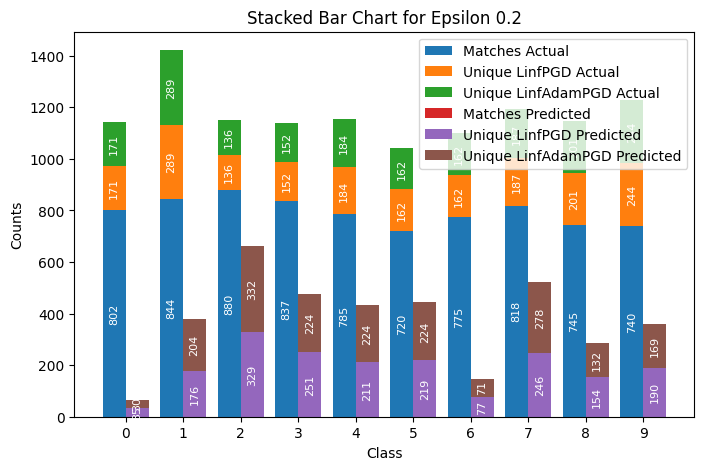

In [25]:
import matplotlib.pyplot as plt
import numpy as np

num_classes = 10  # Assuming 10 classes
bar_width = 0.4

def add_individual_bar_labels(bars, data):
    for bar, value in zip(bars, data):
        height = bar.get_height()
        if height > 0:  # Only display label if bar segment is large enough
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, int(value),
                     ha='center', va='center', color='white', fontsize=8, rotation='vertical')

for eps_index, epsilon in enumerate(epsilons):
    comparison_matrix = comparison_matrices[eps_index]

    indices = np.arange(num_classes)

    plt.figure(figsize=(8,5))
    # Plotting for actual class metrics
    bars_act = plt.bar(indices - bar_width/2, comparison_matrix[:, 0], bar_width, label='Matches Actual')
    add_individual_bar_labels(bars_act, comparison_matrix[:, 0])

    bars_act_unique = plt.bar(indices - bar_width/2, comparison_matrix[:, 2], bar_width, bottom=comparison_matrix[:, 0], label='Unique LinfPGD Actual')
    add_individual_bar_labels(bars_act_unique, comparison_matrix[:, 2])

    bars_act_unique_adam = plt.bar(indices - bar_width/2, comparison_matrix[:, 4], bar_width, bottom=comparison_matrix[:, 0] + comparison_matrix[:, 2], label='Unique LinfAdamPGD Actual')
    add_individual_bar_labels(bars_act_unique_adam, comparison_matrix[:, 4])

    # Plotting for predicted class metrics
    bars_pred = plt.bar(indices + bar_width/2, comparison_matrix[:, 1], bar_width, label='Matches Predicted')
    add_individual_bar_labels(bars_pred, comparison_matrix[:, 1])

    bars_pred_unique = plt.bar(indices + bar_width/2, comparison_matrix[:, 3], bar_width, bottom=comparison_matrix[:, 1], label='Unique LinfPGD Predicted')
    add_individual_bar_labels(bars_pred_unique, comparison_matrix[:, 3])

    bars_pred_unique_adam = plt.bar(indices + bar_width/2, comparison_matrix[:, 5], bar_width, bottom=comparison_matrix[:, 1] + comparison_matrix[:, 3], label='Unique LinfAdamPGD Predicted')
    add_individual_bar_labels(bars_pred_unique_adam, comparison_matrix[:, 5])

    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.title(f'Stacked Bar Chart for Epsilon {epsilon}')
    plt.xticks(indices, [f'{i}' for i in range(num_classes)])
    plt.legend()
    plt.show()


In [26]:
import pandas as pd
import plotly.express as px

# Convert your data to a DataFrame
df = pd.DataFrame(comparison_matrices[eps_index], columns=columns, index=rows)

# Create the parallel coordinates plot
fig = px.parallel_coordinates(df, labels={"index": "Class", "value": "Value", "variable": "Metric"})
fig.show()


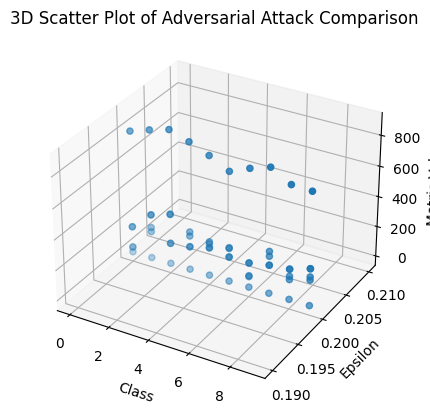

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

num_classes = 10
epsilons = [0.2]

# Example data - replace with your actual data
# Flattening the comparison_matrices and repeating each epsilon and class index
z_data = np.array(comparison_matrices).flatten()  # Flatten your comparison matrices data
x_data = np.repeat(range(num_classes), len(epsilons)*len(comparison_matrices[0][0]))  # Repeat each class index
y_data = np.tile(epsilons, num_classes*len(comparison_matrices[0][0]))  # Repeat the epsilon array for each class

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_data, y_data, z_data)

ax.set_xlabel('Class')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Metric Value')
plt.title('3D Scatter Plot of Adversarial Attack Comparison')
plt.show()



# **Plotting the bar chart for true label counts and predicted label counts**


308/308 [==============================] - 4s 13ms/step


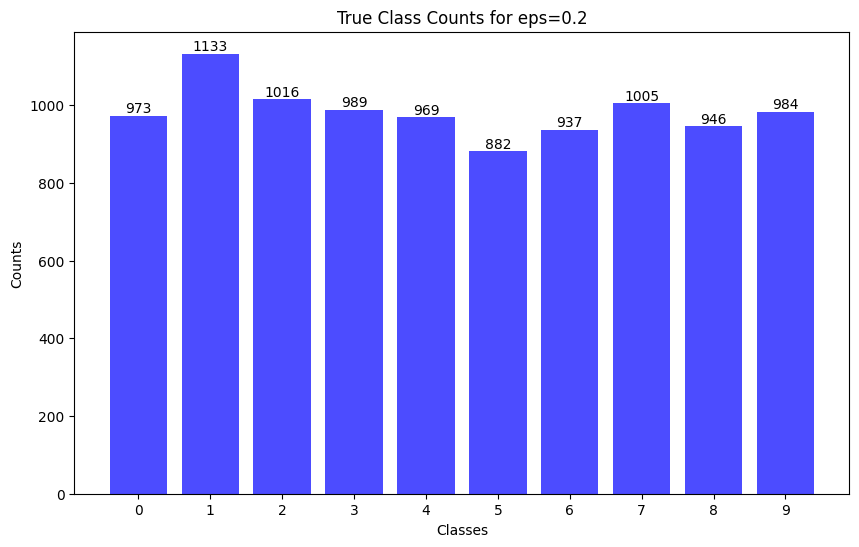

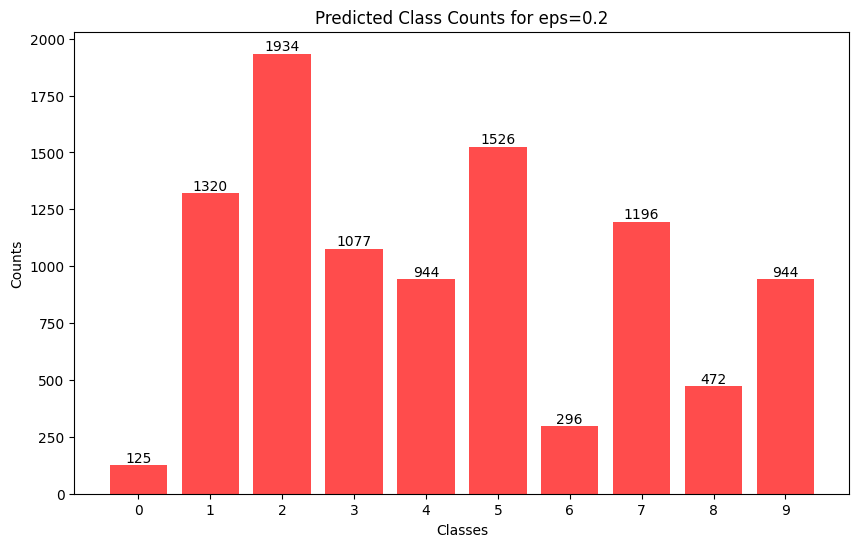

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, advs_ in zip(epsilons, adam_clipped_advs):
    # Predict the labels of the adversarial examples
    adam_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in true labels
    true_label_counts = np.sum(cm, axis=1)

    # Count of each class in predicted labels
    predicted_label_counts = np.sum(cm, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), true_label_counts, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'True Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    # Plotting the bar chart for predicted label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), predicted_label_counts, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()




308/308 [==============================] - 4s 13ms/step


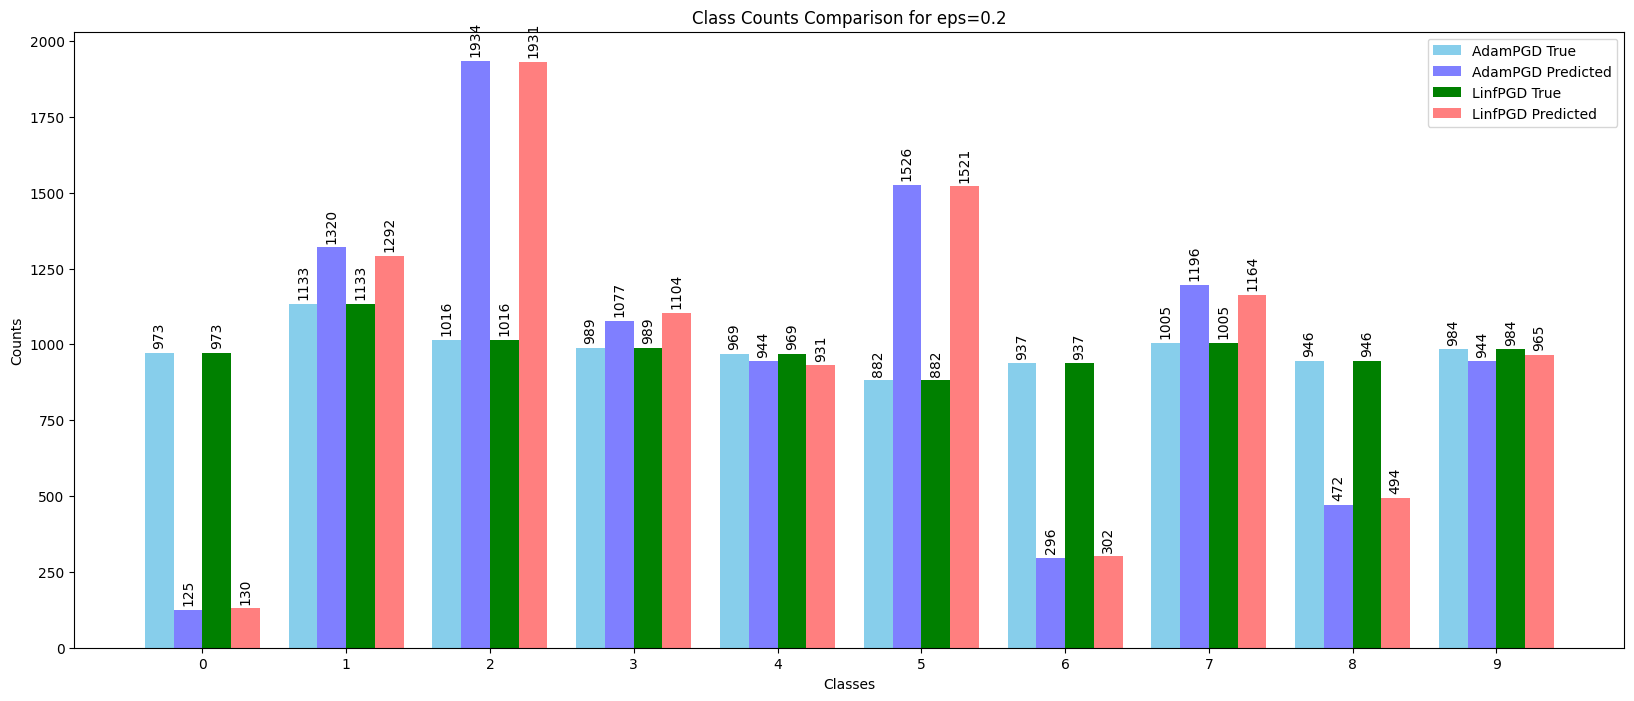

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming fgsm_advs and linfpgd_advs are arrays containing the adversarial examples
# for each epsilon value for the FGSM and LinfPGD attacks, respectively

for eps_index, eps in enumerate(epsilons):
    # Predict labels for FGSM adversarial examples
    adam_y_adv = np.argmax(model.predict(adam_clipped_advs[eps_index]), axis=1)
    cm_adam = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))
    adam_true_counts = np.sum(cm_adam, axis=1)
    adam_predicted_counts = np.sum(cm_adam, axis=0)

    # Predict labels for LinfPGD adversarial examples
    y_adv_linfpgd = np.argmax(model.predict(linfpgd_clipped_advs[eps_index]), axis=1)
    cm_linfpgd = confusion_matrix(correct_labels, y_adv_linfpgd, labels=range(10))
    linfpgd_true_counts = np.sum(cm_linfpgd, axis=1)
    linfpgd_predicted_counts = np.sum(cm_linfpgd, axis=0)

    # Plotting bar charts for FGSM and LinfPGD attacks
    labels = range(10)
    x = np.arange(len(labels)) * 4  # Increase spacing
    width = 0.8

    fig, ax = plt.subplots(figsize=(20, 8))  # Increase figure size

    # adam bars
    bars_adam_true = ax.bar(x - 1.5*width, adam_true_counts, width, label='AdamPGD True', color='skyblue')
    bars_adam_pred = ax.bar(x - 0.5*width, adam_predicted_counts, width, label='AdamPGD Predicted', color='blue', alpha=0.5)

    # LinfPGD bars
    bars_linfpgd_true = ax.bar(x + 0.5*width, linfpgd_true_counts, width, label='LinfPGD True', color='green')
    bars_linfpgd_pred = ax.bar(x + 1.5*width, linfpgd_predicted_counts, width, label='LinfPGD Predicted', color='red', alpha=0.5)

    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title(f'Class Counts Comparison for eps={eps}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add count annotations on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

    # Add annotations
    autolabel(bars_adam_true)
    autolabel(bars_adam_pred)
    autolabel(bars_linfpgd_true)
    autolabel(bars_linfpgd_pred)

    plt.show()


In [30]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# Assuming y_adv_fgsm and y_adv_linfpgd are the predictions
misclassified_adam = [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(y_adv_linfpgd)) if y_adv_linfpgd[i] != correct_labels[i]]

jaccard_index = jaccard_similarity(misclassified_adam, misclassified_linfpgd)
print(f"Jaccard Similarity: {jaccard_index}")
# Assuming y_adv_fgsm and y_adv_linfpgd are the predicted labels from the FGSM and LinfPGD attacks, respectively
misclassified_adam = [i for i in range(len(adam_y_adv)) if adam_y_adv[i] != correct_labels[i]]
misclassified_linfpgd = [i for i in range(len(y_adv_linfpgd)) if y_adv_linfpgd[i] != correct_labels[i]]

# Find common and unique indices
common_indices = set(misclassified_adam).intersection(set(misclassified_linfpgd))
unique_adam = set(misclassified_adam).difference(common_indices)
unique_linfpgd = set(misclassified_linfpgd).difference(common_indices)

print(f"Commonly Misclassified: {len(common_indices)}")
print(f"Unique in Adam: {len(unique_adam)}")
print(f"Unique in LinfPGD: {len(unique_linfpgd)}")

Jaccard Similarity: 1.0
Commonly Misclassified: 9834
Unique in Adam: 0
Unique in LinfPGD: 0


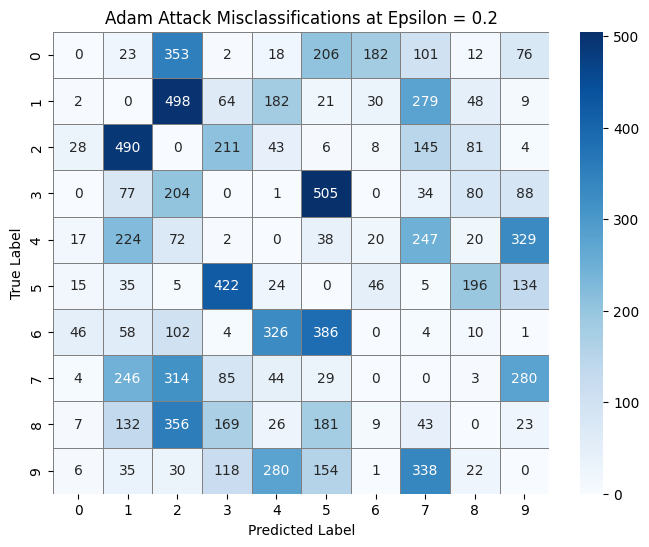

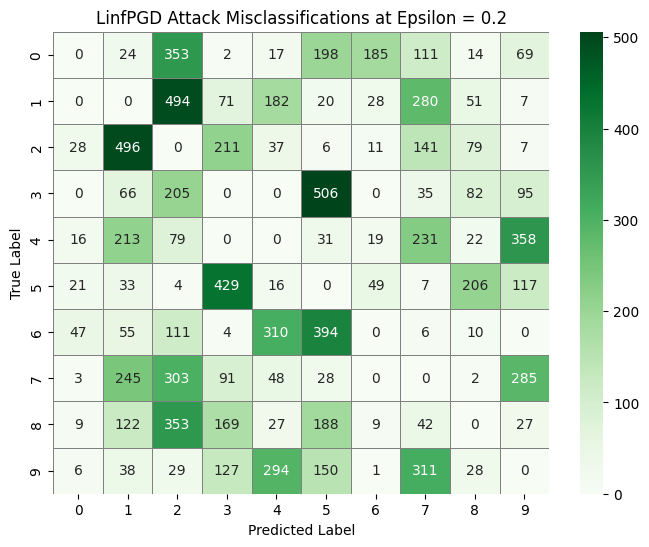

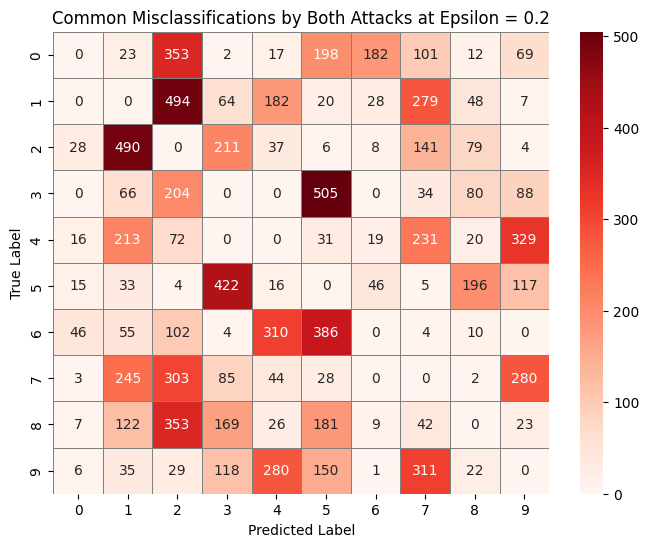

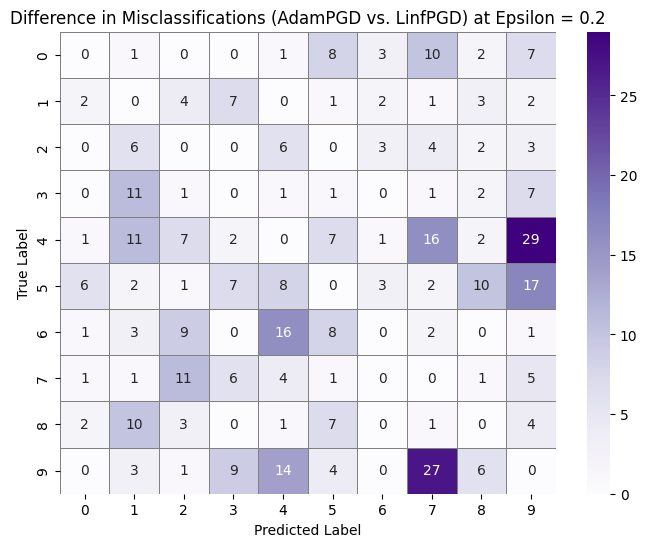

In [31]:
for eps_index, eps in enumerate(epsilons):
    # Assuming you have computed the confusion matrices for FGSM and LinfPGD attacks at each epsilon value
    # cm_fgsm = ... (Computed for FGSM using adversarial examples at eps)
    # cm_linfpgd = ... (Computed for LinfPGD using adversarial examples at eps)

    # Compute common misclassifications
    common_misclassifications = np.minimum(cm_adam, cm_linfpgd)

    # Compute the absolute difference between the confusion matrices
    cm_difference = np.abs(cm_adam - cm_linfpgd)

    # Heatmap for FGSM Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray')
    plt.title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for LinfPGD Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_linfpgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray')
    plt.title(f'LinfPGD Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Common Misclassifications by Both Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(common_misclassifications, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray')
    plt.title(f'Common Misclassifications by Both Attacks at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Differences between Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray')
    plt.title(f'Difference in Misclassifications (AdamPGD vs. LinfPGD) at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


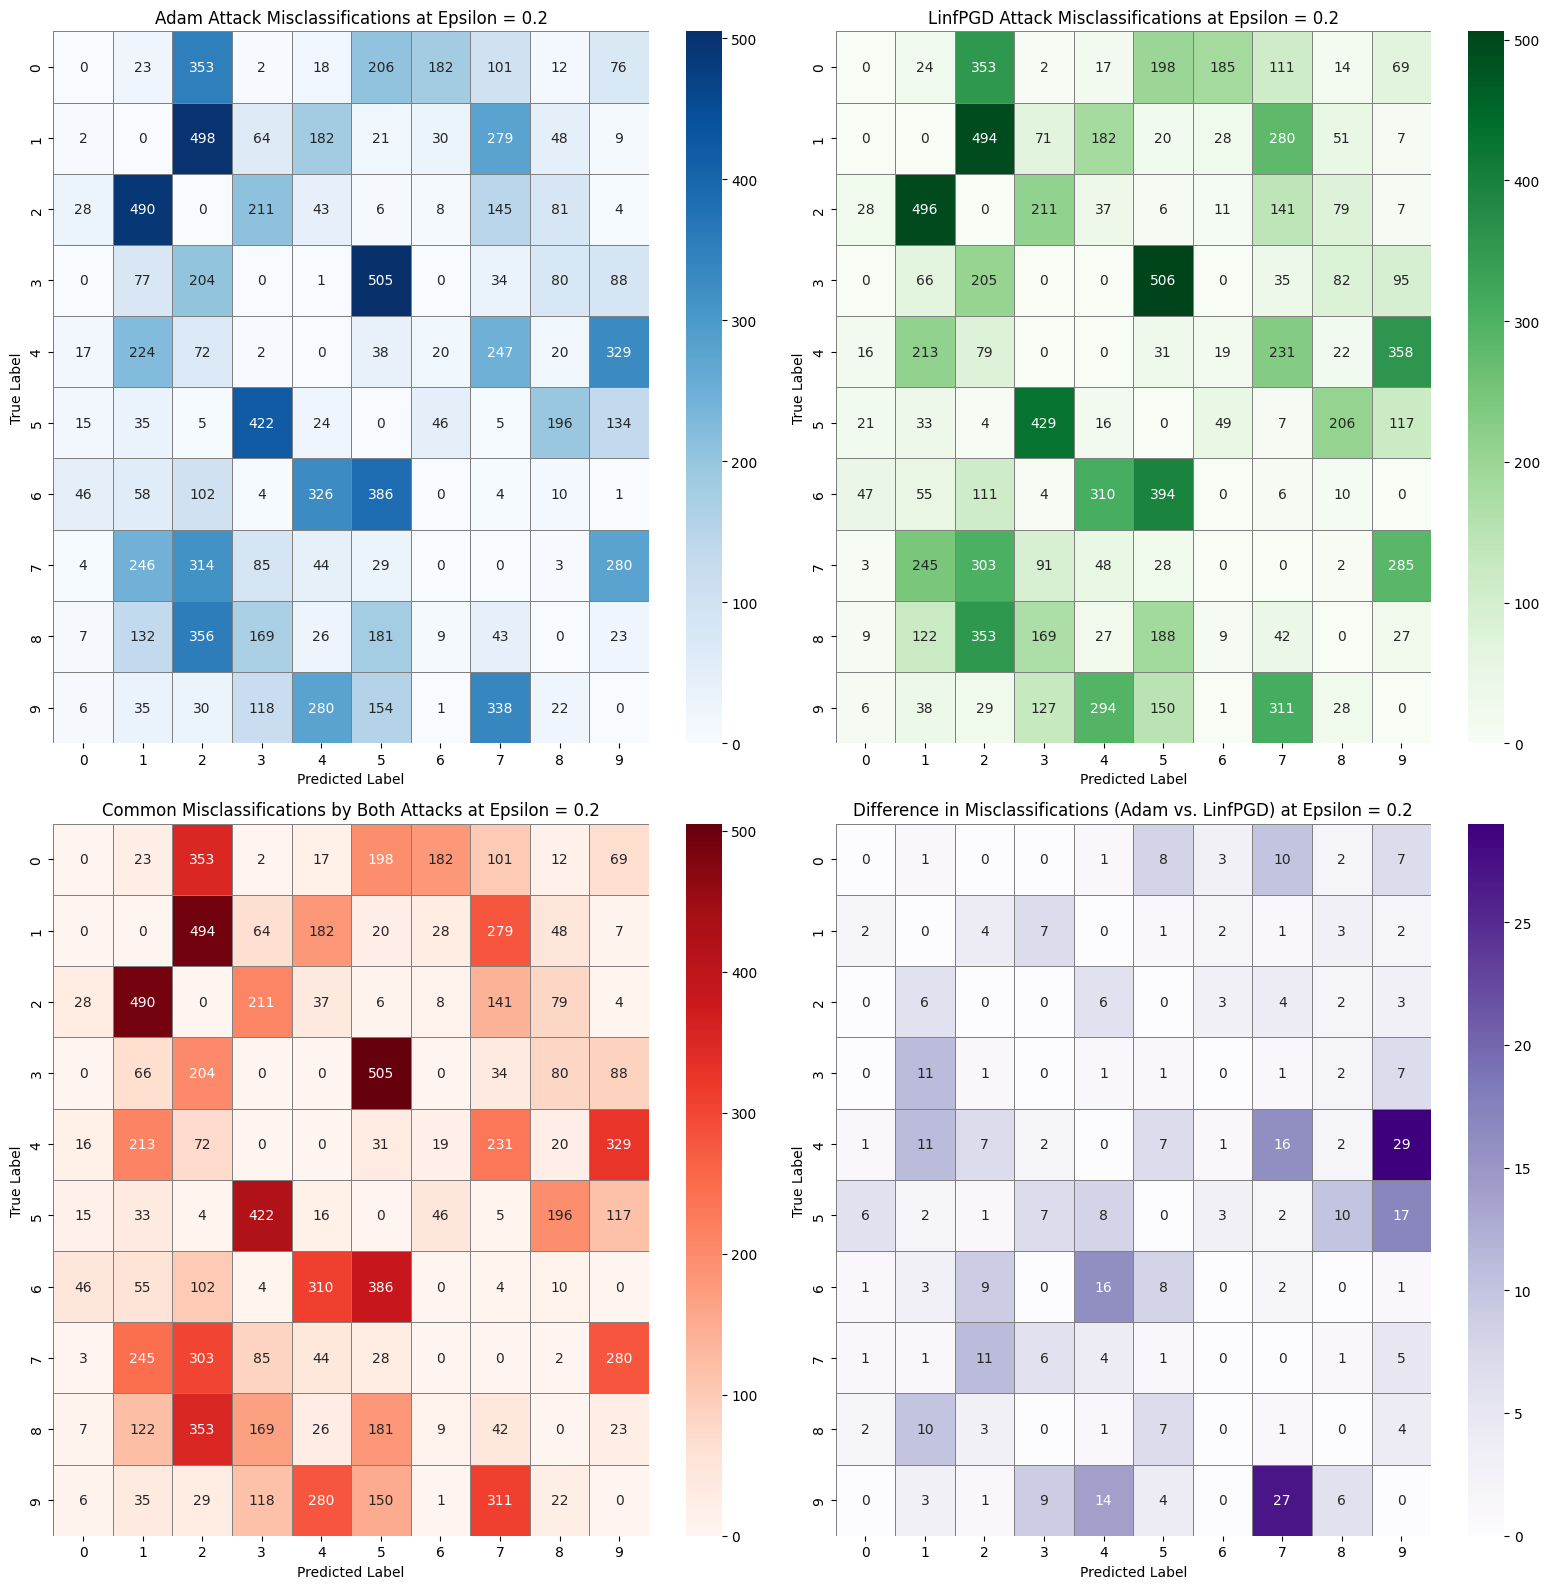

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

for eps_index, eps in enumerate(epsilons):

    # Compute common misclassifications and differences
    common_misclassifications = np.minimum(cm_adam, cm_pgd)
    cm_difference = np.abs(cm_adam - cm_pgd)

    # Create a multi-panel plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    # Adam Attack Misclassifications
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray', ax=axs[0, 0])
    axs[0, 0].set_title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    axs[0, 0].set_ylabel('True Label')
    axs[0, 0].set_xlabel('Predicted Label')

    # LinfPGD Attack Misclassifications
    sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray', ax=axs[0, 1])
    axs[0, 1].set_title(f'LinfPGD Attack Misclassifications at Epsilon = {eps}')
    axs[0, 1].set_ylabel('True Label')
    axs[0, 1].set_xlabel('Predicted Label')

    # Common Misclassifications by Both Attacks
    sns.heatmap(common_misclassifications, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray', ax=axs[1, 0])
    axs[1, 0].set_title(f'Common Misclassifications by Both Attacks at Epsilon = {eps}')
    axs[1, 0].set_ylabel('True Label')
    axs[1, 0].set_xlabel('Predicted Label')

    # Differences between Attacks
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray', ax=axs[1, 1])
    axs[1, 1].set_title(f'Difference in Misclassifications (Adam vs. LinfPGD) at Epsilon = {eps}')
    axs[1, 1].set_ylabel('True Label')
    axs[1, 1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


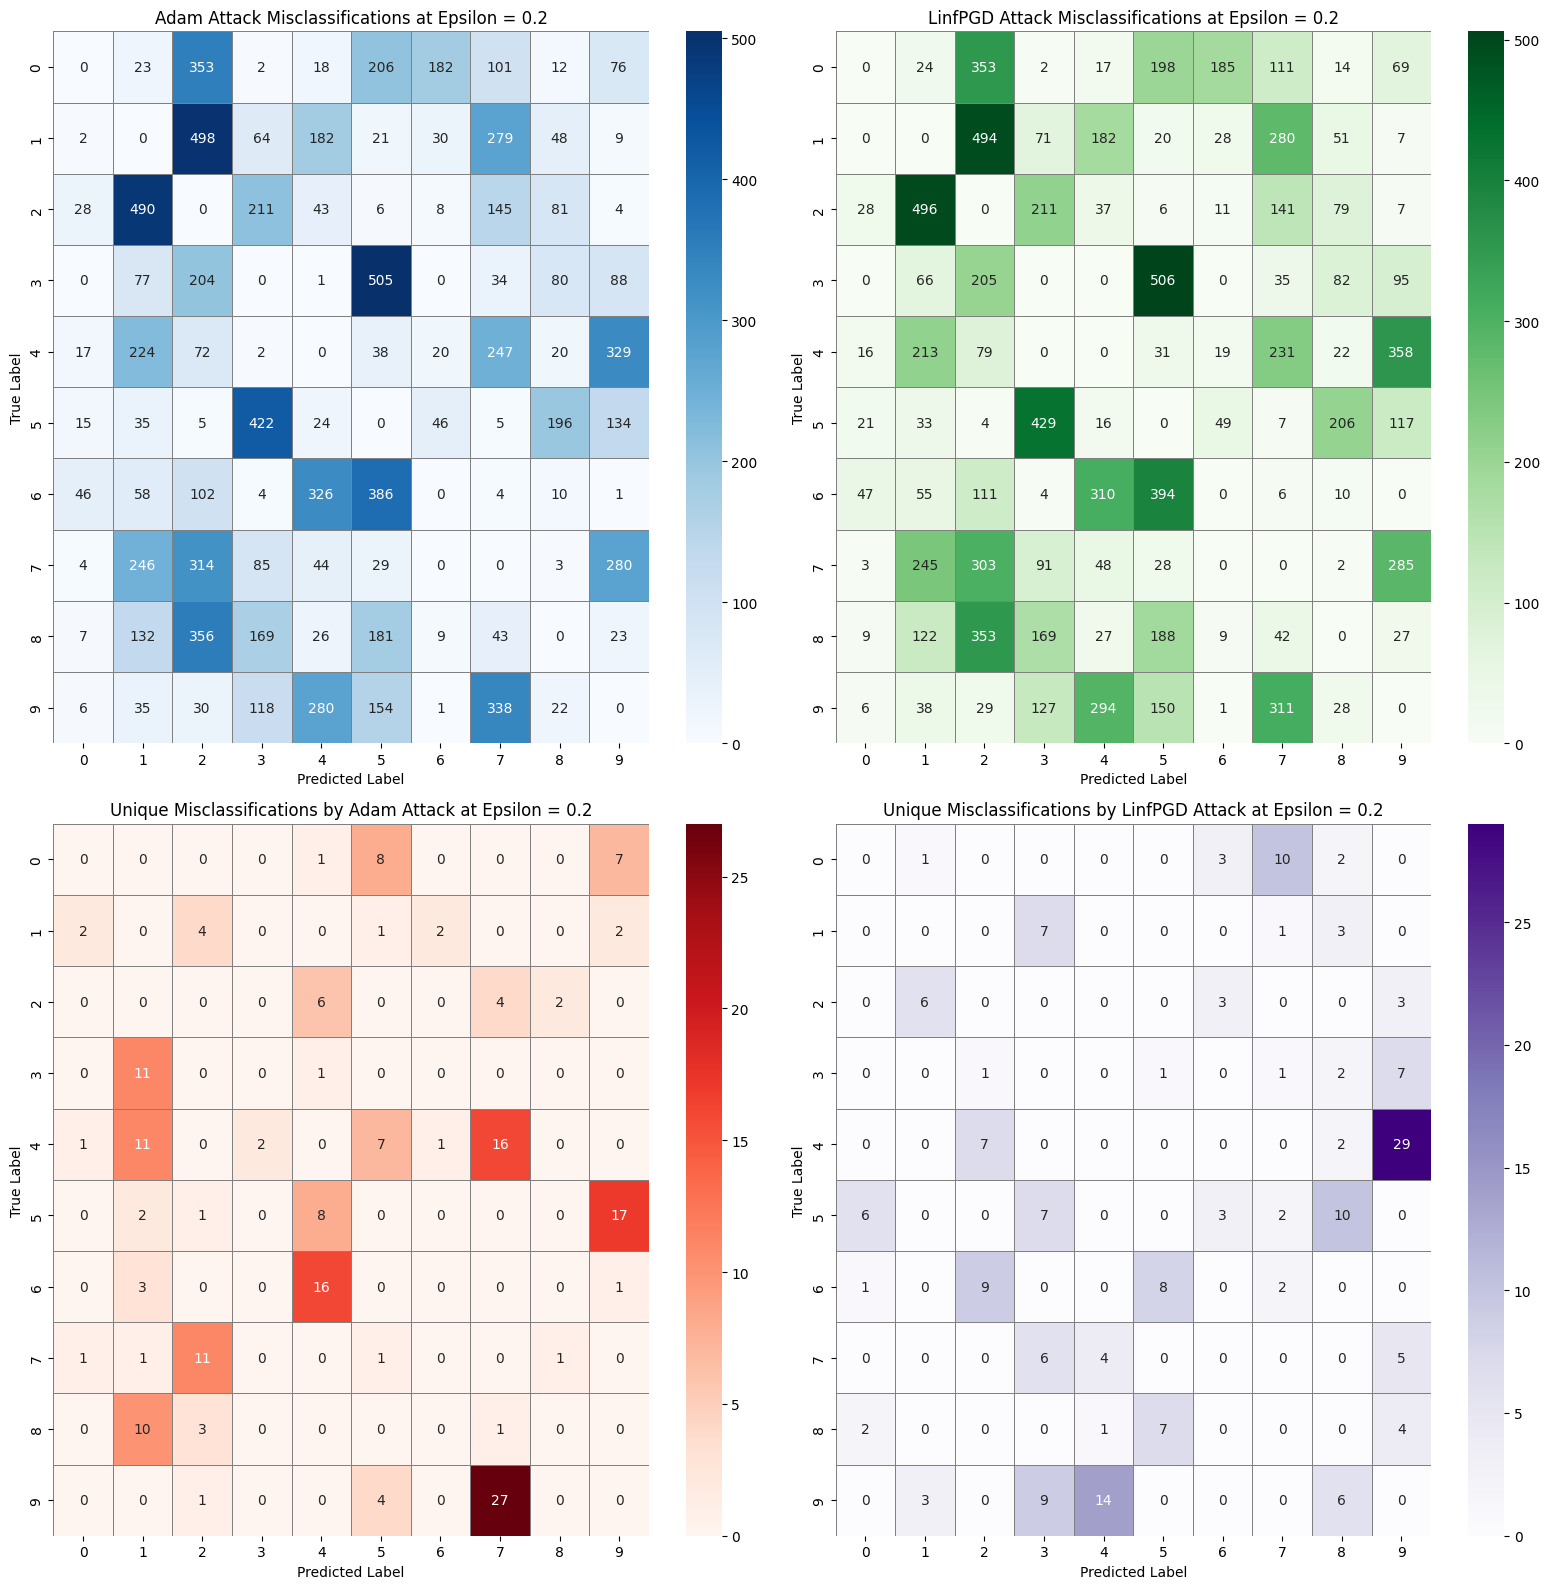

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example epsilons (replace with your actual epsilons)
epsilons = [0.2]

# Example: Loop over different epsilon values
for eps_index, eps in enumerate(epsilons):


    common_misclassifications = np.minimum(cm_adam, cm_linfpgd)
    unique_adam = cm_adam - common_misclassifications
    unique_linfpgd = cm_linfpgd - common_misclassifications

    # Create a multi-panel plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    # Adam Attack Misclassifications
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray', ax=axs[0, 0])
    axs[0, 0].set_title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    axs[0, 0].set_ylabel('True Label')
    axs[0, 0].set_xlabel('Predicted Label')

    # LinfPGD Attack Misclassifications
    sns.heatmap(cm_linfpgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray', ax=axs[0, 1])
    axs[0, 1].set_title(f'LinfPGD Attack Misclassifications at Epsilon = {eps}')
    axs[0, 1].set_ylabel('True Label')
    axs[0, 1].set_xlabel('Predicted Label')

    # Unique Misclassifications for Adam Attack
    sns.heatmap(unique_adam, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray', ax=axs[1, 0])
    axs[1, 0].set_title(f'Unique Misclassifications by Adam Attack at Epsilon = {eps}')
    axs[1, 0].set_ylabel('True Label')
    axs[1, 0].set_xlabel('Predicted Label')

    # Unique Misclassifications for LinfPGD Attack
    sns.heatmap(unique_linfpgd, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray', ax=axs[1, 1])
    axs[1, 1].set_title(f'Unique Misclassifications by LinfPGD Attack at Epsilon = {eps}')
    axs[1, 1].set_ylabel('True Label')
    axs[1, 1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


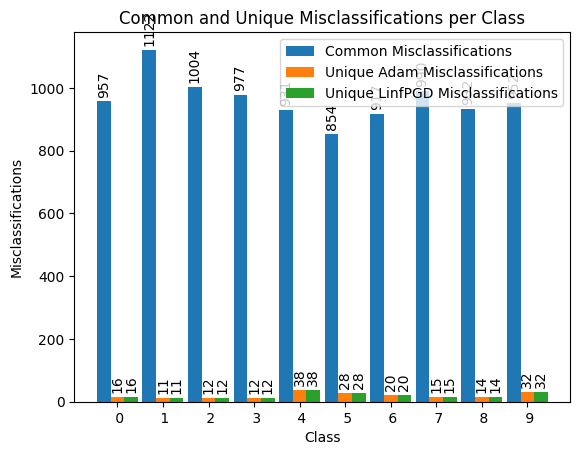

In [34]:
import matplotlib.pyplot as plt
import numpy as np



# Compute common and unique misclassifications
common_misclassifications = np.minimum(cm_adam, cm_pgd)
unique_adam = cm_adam - common_misclassifications
unique_linfpgd = cm_pgd - common_misclassifications

# Sum across rows to get misclassifications for each class
common_counts = np.sum(common_misclassifications, axis=1)
unique_adam_counts = np.sum(unique_adam, axis=1)
unique_linfpgd_counts = np.sum(unique_linfpgd, axis=1)

# Number of classes
n_classes = common_misclassifications.shape[0]

# Set up the bar chart
bar_width = 0.3
index = np.arange(n_classes)

fig, ax = plt.subplots()

bar1 = ax.bar(index, common_counts, bar_width, label='Common Misclassifications')
bar2 = ax.bar(index + bar_width, unique_adam_counts, bar_width, label='Unique Adam Misclassifications')
bar3 = ax.bar(index + 2 * bar_width, unique_linfpgd_counts, bar_width, label='Unique LinfPGD Misclassifications')

# Adding the count above each bar
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90)

add_counts(bar1)
add_counts(bar2)
add_counts(bar3)

# Add labels, title, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Misclassifications')
ax.set_title('Common and Unique Misclassifications per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f' {i}' for i in range(n_classes)])
ax.legend()

plt.show()


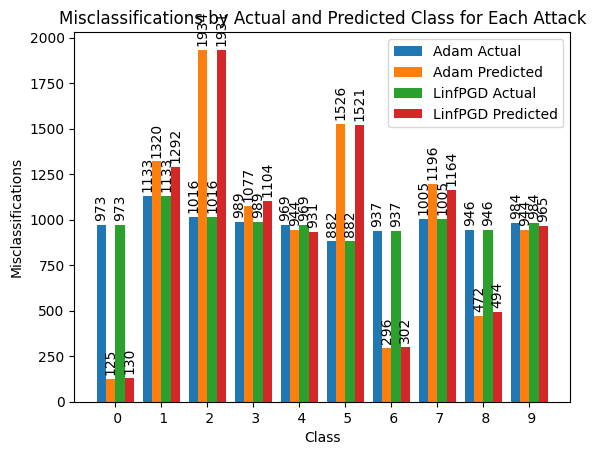

In [35]:
import matplotlib.pyplot as plt
import numpy as np



# Function to calculate misclassifications
def calculate_misclassifications(cm):
    misclassifications_actual = np.sum(cm, axis=1)  # Sum along rows
    misclassifications_predicted = np.sum(cm, axis=0)  # Sum along columns
    return misclassifications_actual, misclassifications_predicted

# Calculate misclassifications
adam_actual, adam_predicted = calculate_misclassifications(cm_adam)
linfpgd_actual, linfpgd_predicted = calculate_misclassifications(cm_linfpgd)

# Number of classes
n_classes = cm_adam.shape[0]

# Set up the bar chart
bar_width = 0.2
index = np.arange(n_classes)

fig, ax = plt.subplots()

# Plotting bars for each type of misclassification
bar1 = ax.bar(index - bar_width, adam_actual, bar_width, label='Adam Actual')
bar2 = ax.bar(index, adam_predicted, bar_width, label='Adam Predicted')
bar3 = ax.bar(index + bar_width, linfpgd_actual, bar_width, label='LinfPGD Actual')
bar4 = ax.bar(index + 2*bar_width, linfpgd_predicted, bar_width, label='LinfPGD Predicted')

# Adding count above each bar with rotation
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)

add_counts(bar1)
add_counts(bar2)
add_counts(bar3)
add_counts(bar4)

# Add labels, title, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Misclassifications')
ax.set_title('Misclassifications by Actual and Predicted Class for Each Attack')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f' {i}' for i in range(n_classes)])
ax.legend()

plt.show()



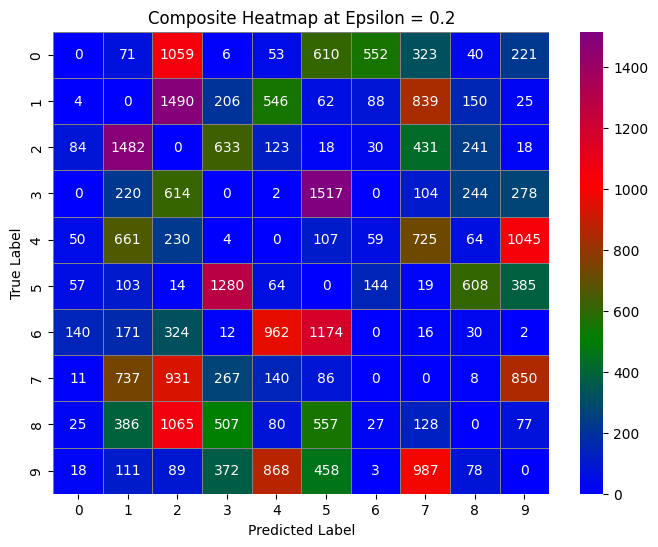

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

for eps_index, eps in enumerate(epsilons):
    # Assuming the confusion matrices are already computed
    common = np.minimum(cm_adam, cm_linfpgd)
    difference = np.abs(cm_adam - cm_linfpgd)

    # Create a composite matrix (this is an example, adjust as needed)
    composite_matrix = cm_adam + cm_linfpgd + common + difference

    # Define a custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "green", "red", "purple"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(composite_matrix, annot=True, fmt='d', cmap=cmap, linewidths=.5, linecolor='gray')
    plt.title(f'Composite Heatmap at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
